1. Load Data

In [16]:
import pandas as pd
import os

resample_X_filename = "re_X_traffic.csv"
resample_y_filename = "re_y_traffic.csv"
filename = 'select_preprocess_label_traffic.csv'
folder = os.path.join("..", "0_dataset", "traffic")
models_folder = "models_traffic"

# resample_X_filename = "re_X_syslog.csv"
# resample_y_filename = "re_y_syslog.csv"
# filename = 'select_preprocess_label_syslog.csv'
# folder = os.path.join("..", "0_dataset", "syslog")
# models_folder = "models_logs"

# resample_X_filename = "re_X_accounting.csv"
# resample_y_filename = "re_y_accounting.csv"
# filename = 'select_preprocess_label_atop.csv'
# folder = os.path.join("..", "0_dataset", "accounting")
# models_folder = "models_accounting"


df = pd.read_csv(os.path.join(folder, filename))
X = df.drop(columns=['Label'])
X = X.values
y = df['Label'].values
y = y.reshape(-1)

2. Define the Models

In [17]:
# linear models
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
# non-linear models
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# ensemble models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle

# balance data
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight

core = 4 # your computer's maximum core numbers, for improving the training speed


models = {}
# linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
# non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Gaussian_NB'] = GaussianNB()
# models['SVC'] = SVC(kernel='rbf', gamma='auto')
models['KNeighbors'] = KNeighborsClassifier(n_jobs=core)
# ensemble models
# models['XGB'] = XGBClassifier(n_jobs=core)
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()

3. Training, testing, and evaluation

In [18]:
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


# training and testing
evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(n_jobs=-1, random_state=48).fit_resample(X_train, y_train)
print(pd.unique(y_test))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))
for name, model in tqdm(models.items()):
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    # y_score = model.predict_proba(X_test)[:, 1] # for AUC curve
    y_hat = model.predict(X_test) # for f1 score
    
    # evaluation
    # balance_accuracy_score
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))


[ 0  8 11  6  7  9 12 14  4  3 16 15 17  2  5  1]
X_train:1248880, y_train:1248880


 33%|███▎      | 4/12 [00:18<00:00, 39.39it/s]c:\Users\user\anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
100%|██████████| 12/12 [03:31<00:00, 17.65s/it]


4. Show the model evalution result (F1 score)

In [19]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math

def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))

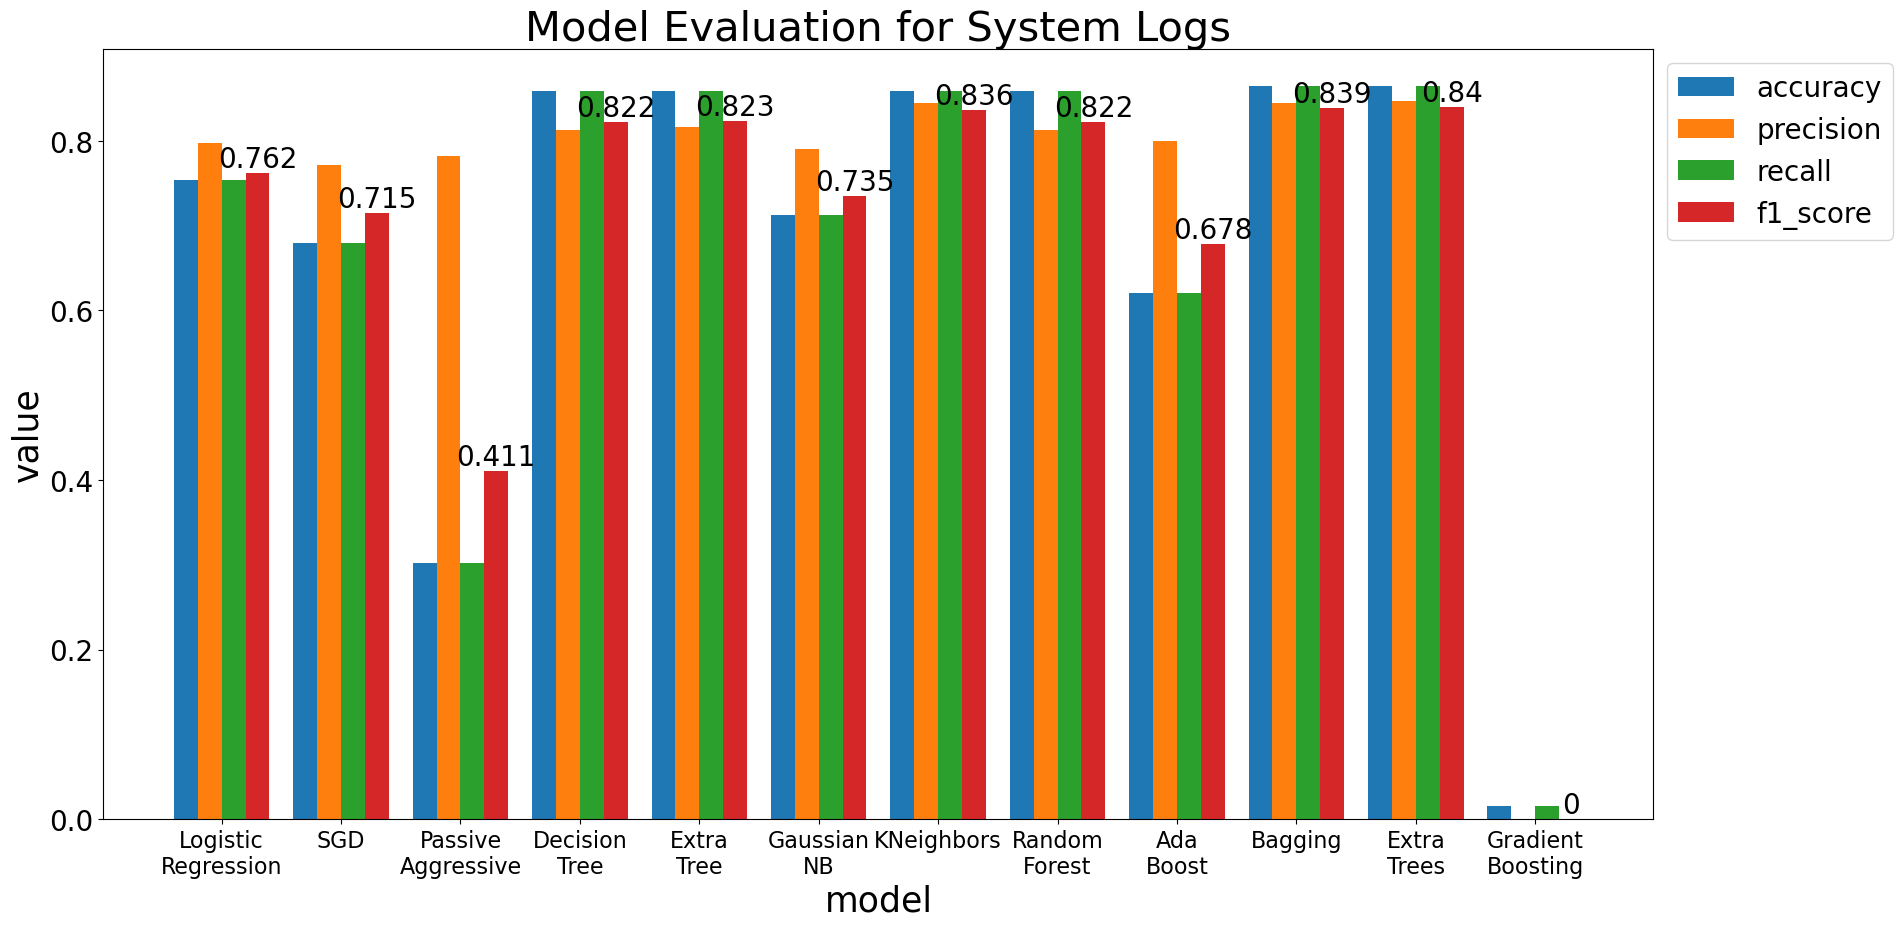

In [20]:
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for Network Traffic', fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=25)
plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 20,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.show()

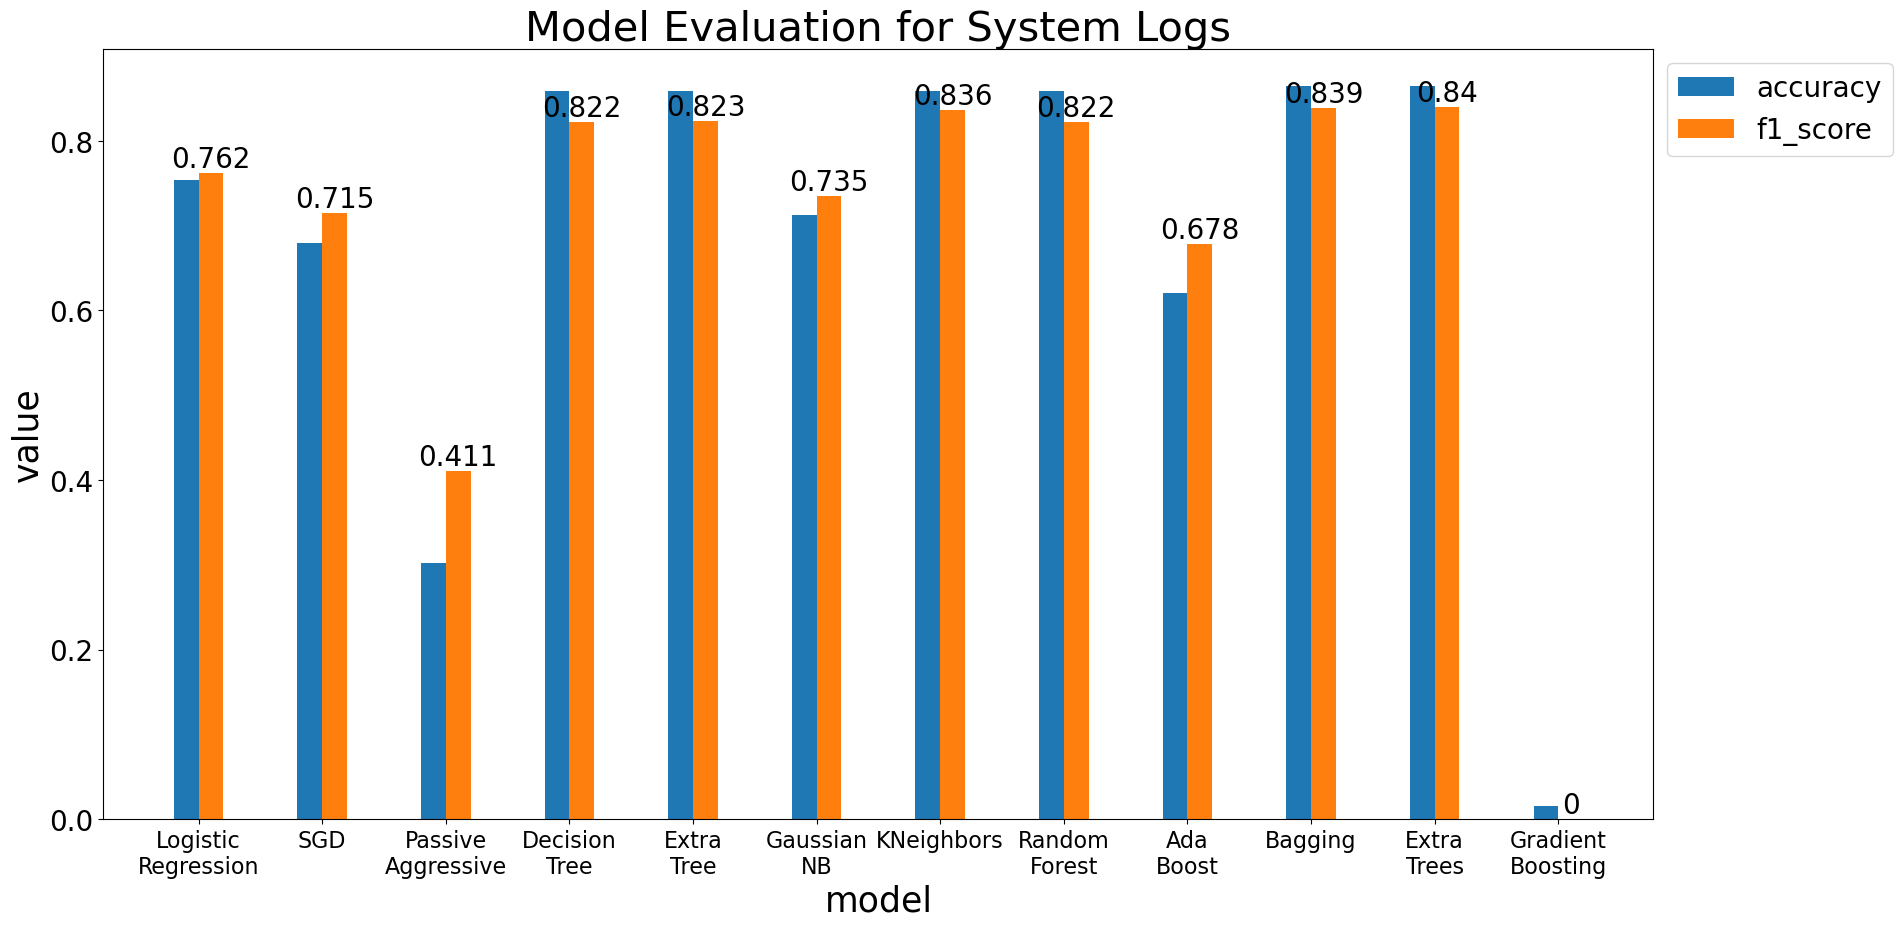

In [21]:
idth = 0.4
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
bar = plt.bar(x+width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.xticks(x+width, models)
plt.title('Model Evaluation for Network Traffic', fontsize=30)
plt.xticks(x+0.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=25)
plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 20,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.show()

5-1. tuning accounting model (confusion matrix, learning curve) 

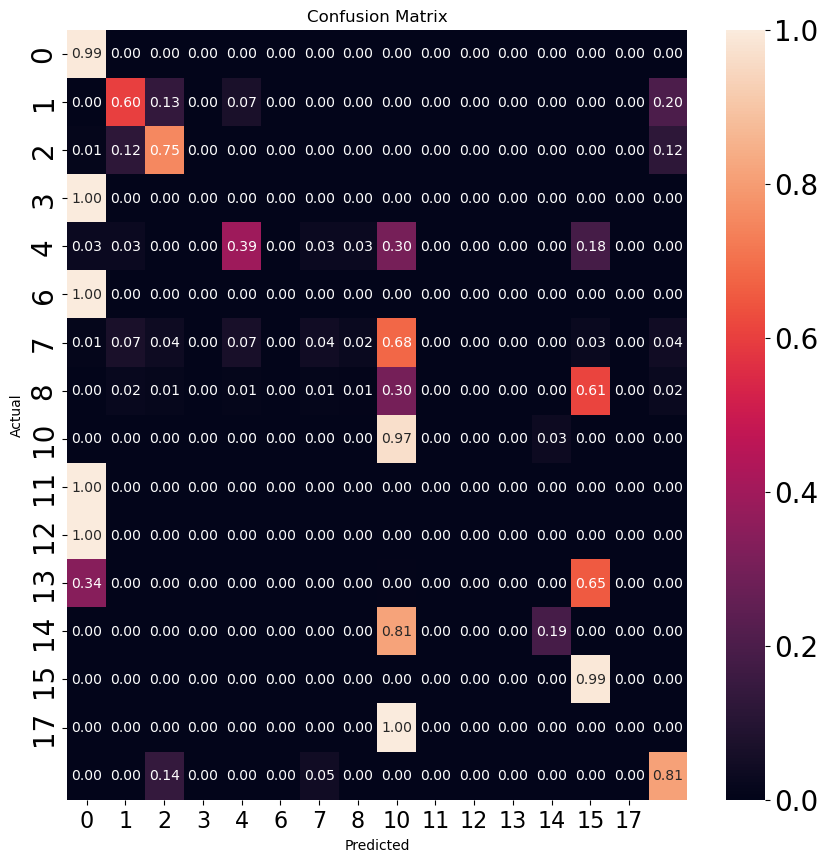

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
name = 'Random_Forest'
model_filename = os.path.join(models_folder, name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)

# accounting
# target_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17]
# syslogs
target_names = [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17]
cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

5-2. tuning system logs model

5-3. tuning network traffic model